In [2]:
'''Implement the Continuous Bag of Words (CBOW) Model. Stages can be:
a. Data preparation
b. Generate training data
c. Train model
d. Output'''

'Implement the Continuous Bag of Words (CBOW) Model. Stages can be:\na. Data preparation\nb. Generate training data\nc. Train model\nd. Output'

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np
%matplotlib inline

In [4]:
#Data Prepration
import re

In [5]:
sentences = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

In [6]:
# Clean Data

# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

In [7]:
#Vocabulary

words = sentences.split()
vocab = set(words)

In [ ]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

#vocab_size: This is the size of your vocabulary, i.e., the total number of unique tokens (words or characters) in your dataset. You've set it to len(vocab), where vocab is likely a list or set of unique words.

#embed_dim: This is the dimensionality of the embedding space. You've set it to 10, meaning each word in your vocabulary will be represented as a 10-dimensional vector. This is a hyperparameter that can be adjusted depending on the complexity of your model and dataset.

#context_size: This refers to the size of the context window when training the model. You've set it to 2, which means each word will be predicted based on the surrounding 2 words (1 word to the left and 1 word to the right, in a typical setting).

In [ ]:
#Implementation

word_to_ix = {word: i for i, word in enumerate(vocab)}
#word_to_ix: This dictionary maps each word in your vocabulary (vocab) to a unique integer index. 
# The enumerate(vocab) function gives an index (i) for each word in the vocabulary, and you're using that index as the key and the word as the value.

ix_to_word = {i: word for i, word in enumerate(vocab)}
#ix_to_word: This dictionary is the inverse of word_to_ix. It maps each index back to the corresponding word.
# This is useful when you need to convert a predicted index back into a word.

In [ ]:
# Data bags

# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

#Data Structure: You are building a list of tuples, where each tuple consists of:

#context: A list of words surrounding a target word (2 words before and 2 words after).
#target: The current word being predicted by the context.
#Loop: The loop iterates through the words list (from index 2 to len(words) - 2), ensuring that the target word has 2 words before and 2 words after it (i.e., a context size of 2).

#Appending Data: For each word i in the range, the context is the 2 preceding and 2 succeeding words, and the target is the word at position i.

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea')]


In [ ]:
#Embedding
embeddings =  np.random.random_sample((vocab_size, embed_dim))

#Initializes a random embedding matrix of shape (vocab_size, embed_dim), where each word in your vocabulary is represented by a random vector of length embed_dim (in this case, 10).

#This matrix will be refined during training, where the embeddings (vectors) for words are adjusted to capture semantic relationships based on the context and target pairs you provide.

In [ ]:
# Linear Model
def linear(m, theta):
    w = theta
    return m.dot(w)

#n short, the linear function calculates the dot product between a matrix m (context word embeddings) 
# and a vector theta (target word embedding). It essentially measures the similarity between the context and target word embeddings.

In [ ]:
# Log softmax + NLLloss = Cross Entropy

def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

#The log_softmax function computes the log of the softmax values,
#  which is useful for tasks like classification, and it helps in calculating cross-entropy loss efficiently.

In [ ]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

"""logs: This is the input to the loss function, typically the output of the log_softmax function. It is a matrix where each row corresponds to the log-probabilities of all classes for a given example.

targets: This is an array of the true class labels (indices) for each example. Each value in targets is an index corresponding to the correct class for that particular sample.

logs[range(len(targets)), targets]: This selects the log-probabilities for the correct classes. range(len(targets)) provides the row indices (for each sample), and targets provides the column indices (for the correct class).

out.sum(): This computes the sum of the log-probabilities for the correct class for all samples.

-out.sum() / len(out): The negative sum of the log-probabilities is averaged over the number of samples, which gives the mean Negative Log-Likelihood Loss. This is the loss value that is minimized during training."""

In [ ]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- out + softmax) / logits.shape[0]


"""logits: These are the raw model outputs (before applying softmax), which represent the unnormalized scores for each class.

target: This is the array of true class labels (indices) for each sample. Each value corresponds to the correct class for that sample.

out = np.zeros_like(logits): Creates a zero matrix of the same shape as logits. This will eventually be used to represent the one-hot encoding of the correct class.

out[np.arange(len(logits)), target] = 1: This sets the appropriate element in the out matrix to 1 for each sample's correct class (this is the one-hot encoding of the correct labels).

softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True): This computes the softmax function. It exponentiates the logits, then normalizes the values across each sample to get the class probabilities.

return (- out + softmax) / logits.shape[0]:

- out + softmax: This computes the element-wise difference between the softmax output and the one-hot encoded target labels (which is effectively the cross-entropy loss).
/ logits.shape[0]: This averages the loss over all samples"""

In [ ]:
#Forward function

def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)

    return m, n, o

"""context_idxs: This is a list or array of indices corresponding to the context words for a given target word. Each index refers to a word in the vocabulary.

theta: This is the target word's embedding (the weight vector you're trying to learn for the target word).

m = embeddings[context_idxs].reshape(1, -1):

context_idxs provides the indices of the context words.
embeddings[context_idxs] retrieves the corresponding embedding vectors for the context words.
.reshape(1, -1) reshapes the context embeddings into a single row (flattening the context vectors into one vector). This is necessary for matrix multiplication in the next step.
n = linear(m, theta):

This applies a linear transformation (typically a dot product) between the reshaped context embeddings m and the target word's embedding theta. The result n is a raw score (logits) that represents the similarity between the context and the target word.
o = log_softmax(n): This applies the log-softmax function to the raw output n, converting it into log-probabilities.

return m, n, o: The function returns:

m: The reshaped context embeddings.
n: The raw scores (logits).
o: The log-probabilities after applying the softmax."""

In [17]:
def backward(preds, theta, target_idxs):
    m, n, o = preds

    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)

    return dw

In [18]:
# Optimize function

def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

In [19]:
# Training

#Genrate training data

theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [20]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)


    epoch_losses[epoch] = losses

Text(0, 0.5, 'Losses')

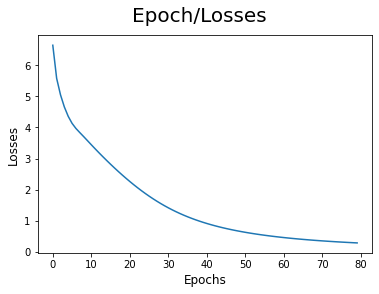

In [21]:
# Analyze
# Plot loss/epoch

ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [22]:
# Predict function

def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]

    return word

In [23]:
# (['we', 'are', 'to', 'study'], 'about')
predict(['we', 'are', 'to', 'study'])

'about'

In [24]:
# Accuracy

def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1

    return (1 - (wrong / len(data)))

In [25]:
accuracy()

1.0

In [26]:
predict(['processes', 'manipulate', 'things', 'study'])

'abstract'